![title](img/covid19_cover.png)

### Author: Minger Lin
### Update Date: Jun 22, 2021
### Project: COVID-19 Data Analysis and Visualization

# Part 1: Analyzing the most recent condition in the United States

### Goal:
We need a strong model that predicts how the virus could spread across different counties in California and states. The goal for this task is to build a model that predicts the spread of the virus in the next 30 days

### Tasks to be performed:
- Analysing the present condition in the U.S.
- Is this trend similar to other countries with large population? (India, China, Brazil, Russia and the United Kingdom)
- Exploring the world wide data
- Forecasting the world wide COVID-19 cases using Prophet

### Importing the required libraries

In [101]:
# importing the requires libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go
import plotly.express as px
from fbprophet import Prophet

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

### Tracking major moments of COVID-19 pandemic in the U.S.:

_**January 21, 2020**_
CDC Confirms First US Coronavirus Case
<br>

_**March 13, 2020**_
President Donald Trump Declares COVID-19 a National Emergency
<br>

_**March 19, 2020**_
California Issues Statewide Stay-at-Home Order
<br>

_**May 28, 2020**_
US COVID-19 Deaths Pass the 100,000 Mark
<br>

_**June 10, 2020**_
US COVID-19 Cases Reach 2 Million
<br>

Sources: https://www.ajmc.com/view/a-timeline-of-covid19-developments-in-2020

### 1.1 Load data sets

**Data Source**: JHU CSSE COVID-19 Dataset in Github. Downloaded on 6/28/2020.

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data#daily-reports-csse_covid_19_daily_reports

In [102]:
confirmed = pd.read_csv("data/time_series_covid19_confirmed_US.csv")
deaths = pd.read_csv("data/time_series_covid19_deaths_US.csv")
shape = gpd.read_file('data/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
globe_confirmed = pd.read_csv("data/time_series_covid19_confirmed_global.csv")
globe_deaths = pd.read_csv("data/time_series_covid19_deaths_global.csv")
globe_recovered = pd.read_csv("data/time_series_covid19_recovered_global.csv")

### 1.2 Data Cleaning

In [103]:
confirmed = confirmed.rename(columns = {'Admin2': 'County', 'Province_State': 'State'}).drop(['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Combined_Key'], axis = 'columns')
deaths = deaths.rename(columns = {'Admin2': 'County', 'Province_State': 'State'}).drop(['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Combined_Key'], axis = 'columns')

In [104]:
confirmed_state = confirmed.drop(['Lat','Long_','FIPS'], axis = 'columns').groupby('State').sum()
confirmed_state = confirmed_state.reset_index().rename(columns = {'State': 'NAME'})
deaths_state = deaths.drop(['Lat','Long_','FIPS'], axis = 'columns').groupby('State').sum()
deaths_state = deaths_state.reset_index().rename(columns = {'State': 'NAME'})

### 1.3 Analyze the number of Confirmed Cases in the U.S.

We are going to see how's the total Confirmed cases with COVID-19 distributed in the United States on 01/25/2021 using the most recent data.

In [105]:
# highlight the dataframe
US06282020 = confirmed_state.loc[:, ['NAME', '6/28/20']].rename(columns={"NAME":"State"}).set_index('State')
US06282020 = US06282020['6/28/20'].sort_values(ascending=False).to_frame()
print('Total number of Confirmed cases COVID-19 cases across the U.S.:', US06282020["6/28/20"].sum())
US06282020.style.background_gradient(cmap='Reds')

Total number of Confirmed cases COVID-19 cases across the U.S.: 2554116


### 1.4 Analyze the number of Deaths Cases in the U.S.

We are going to see how's the total Deaths cases with COVID-19 distributed in the United States on 06/28/2020 using the most recent data.

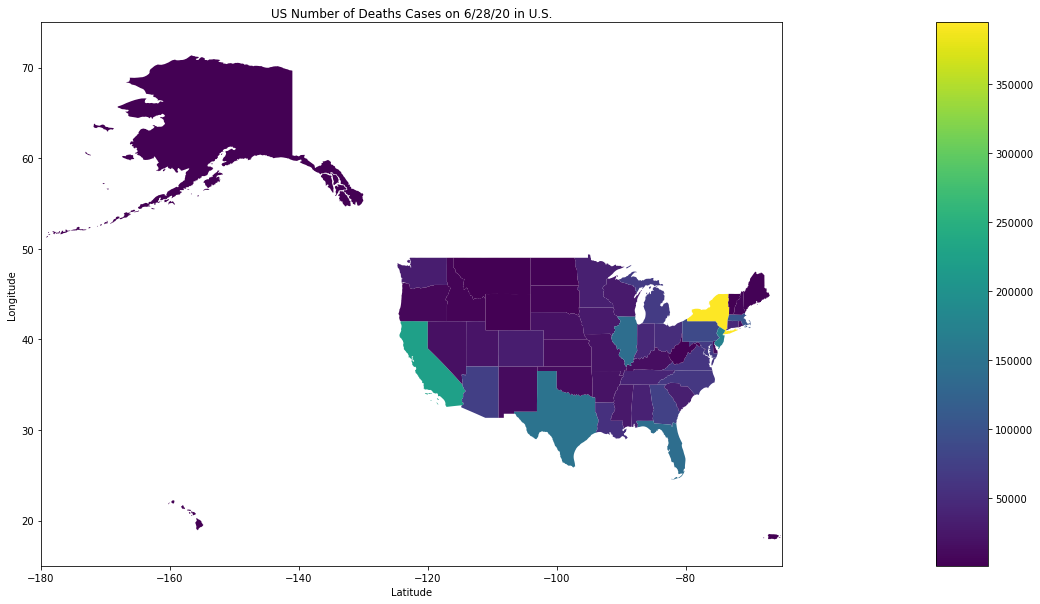

In [106]:
# merge with spatial file and show in as a Map
shape_deaths = shape.merge(deaths_state, how = 'left', on = ['NAME'])
fig, ax = plt.subplots(figsize=(20,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
shape_deaths.plot(column='6/28/20', ax=ax, cax=cax, legend=True)
ax.set_xlim(-180,-65);
ax.set_ylim(15,75);
ax.set_xlabel("Latitude");
ax.set_ylabel("Longitude");
ax.set_title("US Number of Deaths Cases on 6/28/20 in U.S.");

# Part 2: Is this trend similar to other countries with large population?

Let's take a look at the trend of comfirmed cases in the U.S. compares to other countries like India, China, Brazil, Russia and the United Kingdom

In [107]:
globe_confirmed_other = globe_confirmed.drop(['Province/State','Lat','Long'],axis="columns").groupby('Country/Region').sum()
# find the countries
globe_confirmed_other = globe_confirmed_other.loc[["India","China","Brazil","Russia","United Kingdom","US"]]
globe_confirmed_other_short = globe_confirmed_other.T.reset_index().rename(columns={"index":"Date"})

In [108]:
fig = px.line(globe_confirmed_other_short, x="Date", y=globe_confirmed_other_short.columns, 
              color="Country/Region", title="Confirmed Cases in Selected Countries",
             labels=dict(Date="Date", value="Number of Case"))
fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x")

fig.show()

# Part 3: Exploring the world wide data

In [109]:
globe_confirmed_clean = globe_confirmed.drop(['Province/State','Lat','Long'],axis="columns").sum(axis=0).to_frame().iloc[1:].rename(columns={0:"Confirmed"})
globe_deaths_clean = globe_deaths.drop(['Province/State','Lat','Long'],axis="columns").sum(axis=0).to_frame().iloc[1:].rename(columns={0:"Deaths"})
globe_recovered_clean = globe_recovered.drop(['Province/State','Lat','Long'],axis="columns").sum(axis=0).to_frame().iloc[1:].rename(columns={0:"Recovered"})

In [110]:
#Plotting datewise confirmed cases
fig = go.Figure()
fig.add_trace(go.Scatter(x=globe_confirmed_clean.index, y=globe_confirmed_clean['Confirmed'], mode='lines+markers', name='Confirmed',line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=globe_deaths_clean.index, y=globe_deaths_clean['Deaths'], mode='lines+markers', name='Deaths', line=dict(color='Red', width=2)))
fig.add_trace(go.Scatter(x=globe_recovered_clean.index, y=globe_recovered_clean['Recovered'], mode='lines+markers', name='Recovered', line=dict(color='Green', width=2)))
fig.update_layout(title='Worldwide COVID-19 Cases', xaxis=dict(title='Date'),yaxis=dict(title='Number of Cases'))
fig.show()

# Part 4:  Forecasting Total Number of Cases Worldwide

**Prophet** is open source software released by Facebookâ€™s Core Data Science team. It is available for download on CRAN and PyPI.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Source: https://facebook.github.io/prophet/

### 4.1 Data Cleaning 

In [111]:
globe_confirmed4 = globe_confirmed_clean.reset_index().rename(columns={"index":"ds","Confirmed":"y"})
globe_confirmed4['ds'] = pd.to_datetime(globe_confirmed4['ds'])
globe_deaths4 = globe_deaths_clean.reset_index().rename(columns={"index":"ds","Deaths":"y"})
globe_deaths4['ds'] = pd.to_datetime(globe_deaths4['ds'])

### 4.2 Forecasting Confirmed COVID-19 Cases Worldwide with Prophet (Base model)
Generating a 30-days ahead forecast of confirmed cases of NCOVID-19 using Prophet, with 95% prediction interval by creating a base model with no tweaking of seasonality-related parameters and additional regressors.

In [112]:
# created the model and fit the dataframe
model_confirmed = Prophet(interval_width=0.95)
model_confirmed.fit(globe_confirmed4)
future = model_confirmed.make_future_dataframe(periods=30)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
184 2020-07-24
185 2020-07-25
186 2020-07-26
187 2020-07-27
188 2020-07-28

In [113]:
forecast = model_confirmed.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
184 2020-07-24  1.338719e+07  1.293694e+07  1.384336e+07
185 2020-07-25  1.352436e+07  1.307587e+07  1.398569e+07
186 2020-07-26  1.365651e+07  1.316866e+07  1.415727e+07
187 2020-07-27  1.377378e+07  1.322924e+07  1.430216e+07
188 2020-07-28  1.390805e+07  1.334262e+07  1.445139e+07

### 4.3: Plot the forecast for comfirmed data set

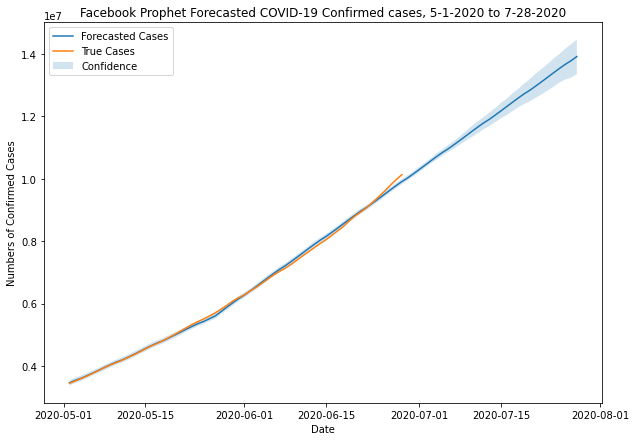

In [121]:
to_plot = forecast[forecast.ds > '2020-05-01'].merge(globe_confirmed4, how='left')
plt.figure(figsize = (10,7));
plt.plot(to_plot['ds'], to_plot['yhat'], label='Forecasted Cases')
plt.plot(to_plot['ds'], to_plot['y'], label='True Cases')
plt.fill_between(to_plot['ds'], to_plot['yhat_upper'], to_plot['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Facebook Prophet Forecasted COVID-19 Confirmed cases, 5-1-2020 to 7-28-2020')
plt.legend();
plt.xlabel('Date')
plt.ylabel('Numbers of Confirmed Cases');

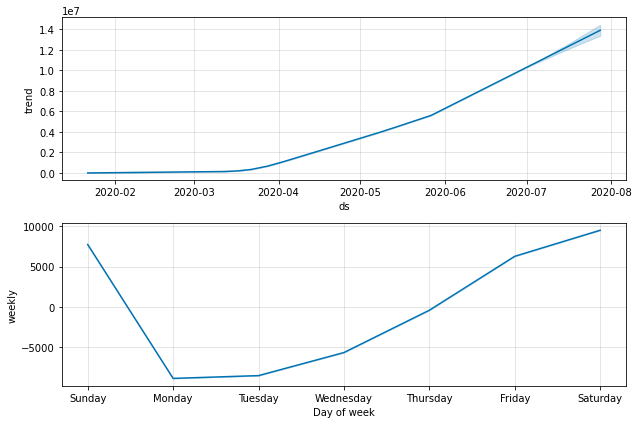

In [122]:
fig2 = model_confirmed.plot_components(forecast)

### 4.4 Inference from the above Analysis and Forecast

We can see from Part1 New York so far has the largest numbers of confirmed case, and California is being on the second on the rank. Will California exceeds New York in the future? It's highly possible since California has a large population

From Part2 we see the number of comfirmed cases grew so far started at the end of March in the United States compared to the world. Brazil started a rapid grow cases at the end of May. As the two largerest populations countries in the world, China and India, have done a good job on controling the spread of the disease so far. 

If we take a look on the graph from Part3, we see the world already hit 10M on June.

Part4 we choose to forecast the Total Number of Comfirmed Cases Worldwide by building a simple model using Prophet.
The weekly seasonality is probably because:
1. People tend to get tested on weekends and their results tend to come back on Wednesdays, creating a peak of reported cases on Wednesdays and valleys on other days. Or,
2. Labs report cases in bulk on certain days.


# Part 5: Update and test the model accuracy

### 5.1 Import newest data

In [128]:
globe_confirmed_new = pd.read_csv("recent_data/time_series_covid19_confirmed_global.csv")
globe_confirmed_new_clean = globe_confirmed_new.drop(['Province/State','Lat','Long'],axis="columns").sum(axis=0).to_frame().iloc[1:].rename(columns={0:"Confirmed"})

In [140]:
globe_confirmed5 = globe_confirmed_new_clean.reset_index().rename(columns={"index":"ds","Confirmed":"y"})
globe_confirmed5['ds'] = pd.to_datetime(globe_confirmed5['ds'])
to_plot5 = forecast.merge(globe_confirmed5[globe_confirmed5.ds<='7/28/20'],how='left')

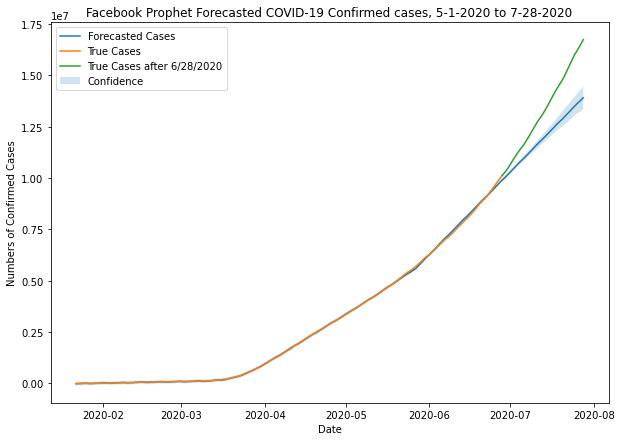

In [146]:
before = to_plot5[to_plot5.ds<="6/28/2020"]
after = to_plot5[to_plot5.ds>="6/28/2020"]
plt.figure(figsize = (10,7));
plt.plot(to_plot5['ds'], to_plot5['yhat'], label='Forecasted Cases')
plt.plot(before['ds'], before['y'], label='True Cases')
plt.plot(after['ds'], after['y'], label='True Cases after 6/28/2020')
plt.fill_between(to_plot5['ds'], to_plot5['yhat_upper'], to_plot5['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Facebook Prophet Forecasted COVID-19 Confirmed cases, 5-1-2020 to 7-28-2020')
plt.legend();
plt.xlabel('Date')
plt.ylabel('Numbers of Confirmed Cases');